In [45]:
%%capture
#pip install scipy

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Dataset

This dataset contains data from 90189 players playing the testing version of the application. Dataset contains these columns:
- **userid** - a unique number identifying player
- **version** - version of the app (either gate_30 or gate_40)
- **sum_gamerounds** - number of rounds played during the first 14 days
- **retention_1** - check if the player returned and played the game 1 day after installation
- **retention_7** - check if the player returned and played the game 7 day after installation


In [81]:
df = pd.read_csv("cookie_cats.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [82]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


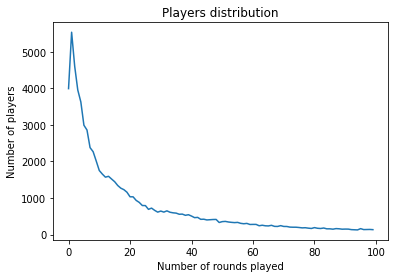

In [83]:
plot = df.groupby("sum_gamerounds")["userid"].count()
data = plot.head(100).plot()
plt.title("Players distribution")
plt.xlabel("Number of rounds played")
plt.ylabel("Number of players")
plt.show()

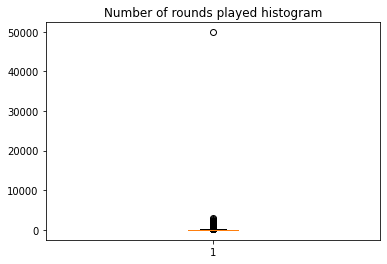

In [84]:
plt.title("Number of rounds played histogram")
plt.boxplot(df["sum_gamerounds"])
plt.show()

It looks like one of the players played 50000 rounds in 14 days.

In [85]:
never_played = df[df["sum_gamerounds"] == 0]["userid"].count()
never_played_perc = (never_played/df["userid"].count())*100
less_than_ten_played = df[df["sum_gamerounds"] <= 29]["userid"].count()
less_than_ten_played_perc = (less_than_ten_played/df["userid"].count())*100
print(f"Number of players that had the game installed but never played it: {never_played} which is about {round(never_played_perc, 2)}%")
print(f"Number of players that had the game installed and played 29 or less rounds: {less_than_ten_played} which is about {round(less_than_ten_played_perc, 2)}%")

Number of players that had the game installed but never played it: 3994 which is about 4.43%
Number of players that had the game installed and played 29 or less rounds: 56920 which is about 63.11%


Lets calculate the mean of the 1-day and 7-day retention

In [86]:
one_day_ret = df["retention_1"].mean()
seven_day_ret = df["retention_7"].mean()

print(f"1-day retention: {round(one_day_ret*100,2)}%")
print(f"7-day retention: {round(seven_day_ret*100,2)}%")

1-day retention: 44.52%
7-day retention: 18.61%


This means that less than half of the players came back and played the game one day after the installation and about 18% of the players came back after 7 days. <br>
We can also calculate the retentions for each testing group.

In [87]:
df_retention_groups = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean"})
df_retention_groups

,userid,retention_1,retention_7
version,,,
gate_30,44700,0.448188,0.190201
gate_40,45489,0.442283,0.182000


There is a very small increase in the group with gate at level 30 compared to gate at 40 in both 1 day and 7 day retentions

# Bootstraping

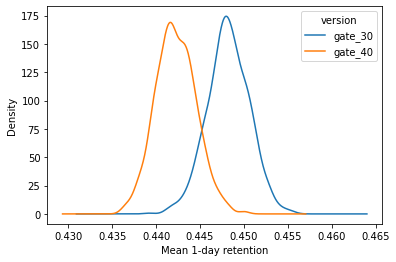

In [94]:
boot_mean_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_1d.append(boot_mean)
boot_mean_1d = pd.DataFrame(boot_mean_1d)
ax = boot_mean_1d.plot.kde()
ax.set_xlabel('Mean 1-day retention');

Text(0.5, 0, '% difference in means')

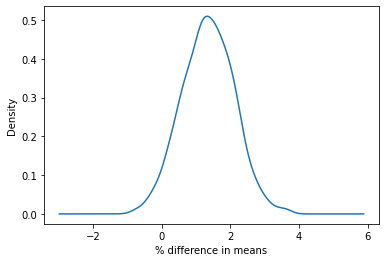

In [95]:
boot_mean_1d['diff'] = ((boot_mean_1d.gate_30 - boot_mean_1d.gate_40) / boot_mean_1d.gate_40 * 100)
ax = boot_mean_1d['diff'].plot.kde()
ax.set_xlabel('% difference in means')

In [96]:
p = (boot_mean_1d['diff'] > 0).mean() * 100
print("{:.2f}%".format(p))

96.50%


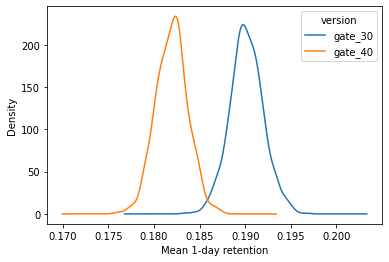

In [97]:
boot_mean_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_mean_7d.append(boot_mean)
boot_mean_7d = pd.DataFrame(boot_mean_7d)
ax = boot_mean_7d.plot.kde()
ax.set_xlabel('Mean 1-day retention');

Text(0.5, 0, '% difference in means')

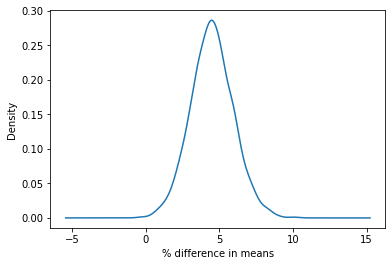

In [98]:
boot_mean_7d['diff'] = ((boot_mean_7d.gate_30 - boot_mean_7d.gate_40) / boot_mean_7d.gate_40 * 100)
ax = boot_mean_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')

In [101]:
p = (boot_mean_7d['diff'] > 0).mean() * 100
print("{:.2f}%".format(p))

99.90%


### Chi-squared test for AB testing
Thanks to the previous observations we can create null and alternative hypothesis.<br>
**H_0** - The retention rate is same for both versions.<br>
**H_1** - The retention rate is higher for the gate at level 30

In [41]:
df_chi = pd.DataFrame(data={"version" : ["gate_30", "gate_40"]})
df_chi["ret_1"] = df[df.retention_1==True].groupby(by="version").count()["retention_1"].values
df_chi["notret_1"] = df[df.retention_1==False].groupby(by="version").count()["retention_1"].values
df_chi["ret_7"] = df[df.retention_7==True].groupby(by="version").count()["retention_7"].values
df_chi["notret_7"] = df[df.retention_7==False].groupby(by="version").count()["retention_7"].values
df_chi

,version,ret_1,notret_1,ret_7,notret_7
0,gate_30,20034,24666,8502,36198
1,gate_40,20119,25370,8279,37210


Calculate the chi-squared statistic and p-value

In [59]:
chi_ret1 = stats.chi2_contingency(df_chi[["ret_1","notret_1"]])
chi_ret7 = stats.chi2_contingency(df_chi[["ret_7","notret_7"]])
print(f"One day retention:\nChi-squared test: {chi_ret1[0]}\np-value: {chi_ret1[1]}\n")
print(f"Seven day retention:\nChi-squared test: {chi_ret7[0]}\np-value: {chi_ret7[1]}")

One day retention:
Chi-squared test: 3.1591007878782262
p-value: 0.07550476210309086

Seven day retention:
Chi-squared test: 9.959086799559165
p-value: 0.0016005742679058301


# <u>Conclusion

- There was a small decrease in one day retention when the gate was moved from level 30 to level 40 (44.8% -> 44,2%)
- According to chi-squared test there was no difference in rates between the two versions at the 5% significance level. We do not reject our H_0 hypothesis.
- There was a small decrease in seven day retention when the gate was moved from level 30 to level 40 (19% -> 18,2%)
- According to chi-squared test there was significant difference in rates between the two versions even at the 1% significance level. We reject our H_0 hypothesis and accept H_1 hypothesis.

- The bootstrap result gives us a good evidence that the 7-day retention is higher when the gate is at round 30. With what in mind, if we want to keep retention at day 1 and 7 higher the gate should not be moved from round 30 to 40

Thanks to chi-square test we gathered enought evidence that 7-day retention is higher when the first gate is at level 30 than when it is at level 40.<br>
The gate should not be moved to level 40 and should be kept at level 30.